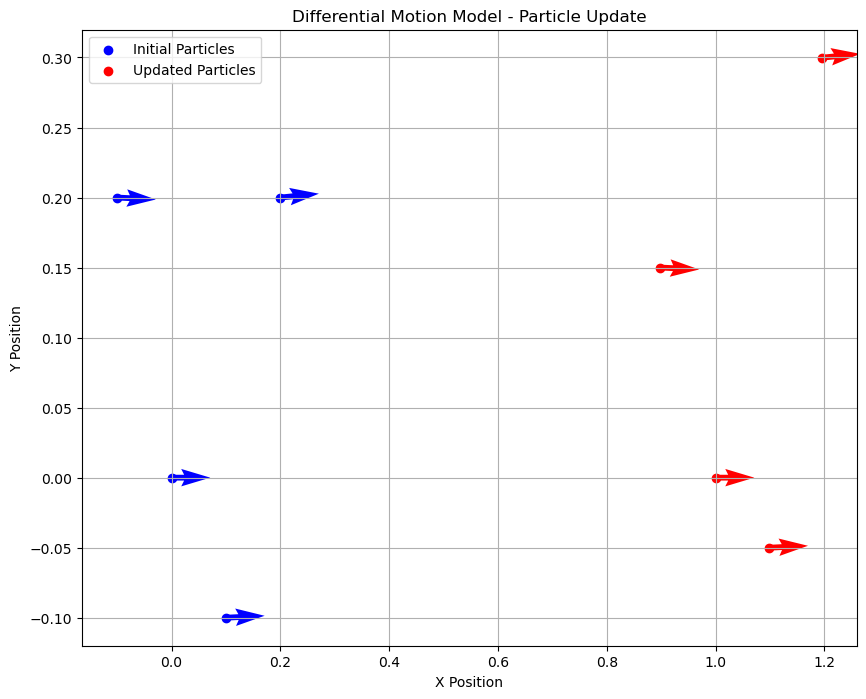

In [14]:
# Import der notwendigen Bibliotheken
import math
import numpy as np
import matplotlib.pyplot as plt

class DifferentialMotionModel:
    def __init__(self, alpha1, alpha2, alpha3, alpha4, alpha5):
        self.alpha1 = alpha1
        self.alpha2 = alpha2
        self.alpha3 = alpha3
        self.alpha4 = alpha4
        self.alpha5 = alpha5

    def odometry_update(self, particles, pose, delta):
        old_pose = [pose[0] - delta[0], pose[1] - delta[1], pose[2] - delta[2]]
        
        delta_trans = math.sqrt(delta[0]**2 + delta[1]**2)
        if delta_trans < 0.01:
            delta_rot1 = 0.0
        else:
            delta_rot1 = self.angle_diff(math.atan2(delta[1], delta[0]), old_pose[2])
        delta_rot2 = self.angle_diff(delta[2], delta_rot1)

        delta_rot1_noise = min(abs(self.angle_diff(delta_rot1, 0.0)), abs(self.angle_diff(delta_rot1, math.pi)))
        delta_rot2_noise = min(abs(self.angle_diff(delta_rot2, 0.0)), abs(self.angle_diff(delta_rot2, math.pi)))

        updated_particles = []
        for particle in particles:
            x, y, theta = particle

            # Zufällige Störungen hinzufügen
            delta_rot1_hat = self.angle_diff(
                delta_rot1, 
                np.random.normal(0, math.sqrt(self.alpha1 * delta_rot1_noise**2 + self.alpha2 * delta_trans**2))
            )
            delta_trans_hat = delta_trans - np.random.normal(
                0, math.sqrt(
                    self.alpha3 * delta_trans**2 +
                    self.alpha4 * delta_rot1_noise**2 +
                    self.alpha4 * delta_rot2_noise**2
                )
            )
            delta_rot2_hat = self.angle_diff(
                delta_rot2, 
                np.random.normal(0, math.sqrt(self.alpha1 * delta_rot2_noise**2 + self.alpha2 * delta_trans**2))
            )

            # Partikel aktualisieren
            new_x = x + delta_trans_hat * math.cos(theta + delta_rot1_hat)
            new_y = y + delta_trans_hat * math.sin(theta + delta_rot1_hat)
            new_theta = theta + delta_rot1_hat + delta_rot2_hat

            updated_particles.append([new_x, new_y, new_theta])

        return updated_particles

    @staticmethod
    def angle_diff(a, b):
        diff = (a - b + math.pi) % (2 * math.pi) - math.pi
        return diff if diff >= -math.pi else diff + 2 * math.pi

# Ausgangsdaten
np.random.seed(2)
initial_particles = np.array([
    [0, 0, 0],
    [0.1, -0.1, 0.05],
    [-0.1, 0.2, -0.05],
    [0.2, 0.2, 0.1]
])
delta_motion = [1.0, 0.0, 0.0]
current_pose = [0.0, 0.0, 0.0]

# Modell erstellen
motion_model = DifferentialMotionModel(alpha1=0.00, alpha2=0.00, alpha3=0.00, alpha4=0.000, alpha5=0.00)
updated_particles = motion_model.odometry_update(initial_particles, current_pose, delta_motion)

# Visualisierung
def plot_particles(particles, color, label):
    x = [p[0] for p in particles]
    y = [p[1] for p in particles]
    plt.scatter(x, y, color=color, label=label)
    plt.quiver(x, y, np.cos([p[2] for p in particles]), np.sin([p[2] for p in particles]), color=color, scale=20)

plt.figure(figsize=(10, 8))
plot_particles(initial_particles, color='blue', label='Initial Particles')
plot_particles(updated_particles, color='red', label='Updated Particles')
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Differential Motion Model - Particle Update")
plt.grid()
plt.show()
